In [1]:
# pip install monai

In [2]:
! pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [3]:
import os
import cv2
import random
import shutil
import kagglehub
import numpy as np 
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt
#from monai.losses import HausdorffDTLoss

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import segmentation_models_pytorch as smp

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
images, masks = [], []

## **Get Hard Exudates (IDRID)**

In [6]:
# Get the parent path
hard_path = "/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation"
print(os.listdir(hard_path))

['images', 'masks']


In [7]:
# Get renamed images for hard exudates
for image in os.listdir(os.path.join(hard_path, 'images')):
    
    img_name, ext = os.path.splitext(image)
    images.append(os.path.join(hard_path, 'images', image))
    
    # Get masks for hard exudates
    mask_path = os.path.join(hard_path, 'masks')
    mask_name = img_name + '_EX' + '.tif'
    masks.append(os.path.join(mask_path, mask_name))

In [8]:
print('Size of newly acquired images:', len(images))
print('Size of newly acquired masks:', len(masks))

Size of newly acquired images: 54
Size of newly acquired masks: 54


In [9]:
images[:5]

['/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/images/IDRiD_52.jpg',
 '/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/images/IDRiD_36.jpg',
 '/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/images/IDRiD_13.jpg',
 '/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/images/IDRiD_16.jpg',
 '/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/images/IDRiD_23.jpg']

In [10]:
masks[:5]

['/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/masks/IDRiD_52_EX.tif',
 '/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/masks/IDRiD_36_EX.tif',
 '/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/masks/IDRiD_13_EX.tif',
 '/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/masks/IDRiD_16_EX.tif',
 '/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/masks/IDRiD_23_EX.tif']

## **Get Soft Exudates (IDRID)**

In [11]:
# Get the parent path
soft_path = "/kaggle/input/soft-exudates-segmentation/soft exudates segmentation"
print(os.listdir(soft_path))

['images', 'masks']


In [12]:
# Get renamed images for soft exudates
for image in os.listdir(os.path.join(soft_path, 'images')):
    
    img_name, ext = os.path.splitext(image)
    images.append(os.path.join(soft_path, 'images', image))
    

    # Get masks for soft exudates
    mask_path = os.path.join(soft_path, 'masks')
    mask_name = img_name + '_SE' + '.tif'
    masks.append(os.path.join(mask_path, mask_name))

In [13]:
print('Number of newly acquired images:', len(images))
print('Number of newly acquired masks:', len(masks))

Number of newly acquired images: 94
Number of newly acquired masks: 94


In [14]:
images[-5:]

['/kaggle/input/soft-exudates-segmentation/soft exudates segmentation/images/IDRiD_73.jpg',
 '/kaggle/input/soft-exudates-segmentation/soft exudates segmentation/images/IDRiD_55.jpg',
 '/kaggle/input/soft-exudates-segmentation/soft exudates segmentation/images/IDRiD_38.jpg',
 '/kaggle/input/soft-exudates-segmentation/soft exudates segmentation/images/IDRiD_70.jpg',
 '/kaggle/input/soft-exudates-segmentation/soft exudates segmentation/images/IDRiD_68.jpg']

In [15]:
masks[-5:]

['/kaggle/input/soft-exudates-segmentation/soft exudates segmentation/masks/IDRiD_73_SE.tif',
 '/kaggle/input/soft-exudates-segmentation/soft exudates segmentation/masks/IDRiD_55_SE.tif',
 '/kaggle/input/soft-exudates-segmentation/soft exudates segmentation/masks/IDRiD_38_SE.tif',
 '/kaggle/input/soft-exudates-segmentation/soft exudates segmentation/masks/IDRiD_70_SE.tif',
 '/kaggle/input/soft-exudates-segmentation/soft exudates segmentation/masks/IDRiD_68_SE.tif']

## **Get Normal, Hard & Soft Exudates (e_optha)**

In [16]:
#
optha_path = "/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX"
print(os.listdir(optha_path))

['e_ophta_EX.html', 'EX', 'healthy', 'Annotation_EX']


In [17]:
healthy_mask_dir = "/kaggle/working/healthy_masks"

# If the directory exists, empty it
if os.path.exists(healthy_mask_dir):
    shutil.rmtree(healthy_mask_dir)  # Deletes the entire directory and contents

# Recreate the empty directory
os.makedirs(healthy_mask_dir)

In [18]:
healthy_imgs, healthy_masks = [], []

In [19]:
# Get healthy samples
for patient in os.listdir(os.path.join(optha_path, 'healthy')):

    # For each patient get corresponding images
    for healthy_img in os.listdir(os.path.join(optha_path, 'healthy', patient)):

        # Get image path
        img_path = os.path.join(optha_path, 'healthy', patient, healthy_img)
    
        # Add healthy image directory
        healthy_imgs.append(img_path)
    
        # Create black mask (same width & height)
        image = Image.open(img_path).convert("RGB")
        width, height = image.size
        black_mask = Image.fromarray(np.zeros((height, width), dtype=np.uint8))
    
        # Save mask as .jpg in working directory
        mask_filename = os.path.splitext(healthy_img)[0] + ".jpg"
        mask_path = os.path.join(healthy_mask_dir, mask_filename)
        black_mask.save(mask_path)

        # Add healthy masks
        healthy_masks.append(mask_path)

In [20]:
print('Number of Healthy Images Found', len(healthy_imgs))

Number of Healthy Images Found 35


In [21]:
print('Number of Healthy Masks Created', len(healthy_masks))

Number of Healthy Masks Created 35


In [22]:
healthy_imgs[:5]

['/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/healthy/E0023106/DS000IMS.JPG',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/healthy/E0023106/DS000IMQ.JPG',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/healthy/E0002477/C0022966.jpg',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/healthy/E0002477/C0022964.jpg',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/healthy/E0001663/DS000DPM.JPG']

In [23]:
healthy_masks[:5]

['/kaggle/working/healthy_masks/DS000IMS.jpg',
 '/kaggle/working/healthy_masks/DS000IMQ.jpg',
 '/kaggle/working/healthy_masks/C0022966.jpg',
 '/kaggle/working/healthy_masks/C0022964.jpg',
 '/kaggle/working/healthy_masks/DS000DPM.jpg']

In [24]:
# Get exudated samples
for patient in os.listdir(os.path.join(optha_path, 'EX')):

    # For each patient get corresponding images
    for img in os.listdir(os.path.join(optha_path, 'EX', patient)):

        img_name, ext = os.path.splitext(img)

        # Get image path
        img_path = os.path.join(optha_path, 'EX', patient, img)
    
        # Add image directory
        images.append(img_path)

        # Get mask name
        mask_name = img_name + '_EX' + '.png'
        mask_path = os.path.join(os.path.join(optha_path, 'Annotation_EX', patient), mask_name)
        
        # Add mask
        masks.append(mask_path)

In [25]:
print('Number of newly acquired images:', len(images))
print('Number of newly acquired masks:', len(masks))

Number of newly acquired images: 141
Number of newly acquired masks: 141


In [26]:
images[-5:]

['/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/EX/E0018969/DS000HVG.JPG',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/EX/E0020303/DS000VBZ.JPG',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/EX/E0023776/C0026111.jpg',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/EX/E0023776/C0026113.jpg',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/EX/E0024915/C0010059.jpg']

In [27]:
masks[-5:]

['/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/Annotation_EX/E0018969/DS000HVG_EX.png',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/Annotation_EX/E0020303/DS000VBZ_EX.png',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/Annotation_EX/E0023776/C0026111_EX.png',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/Annotation_EX/E0023776/C0026113_EX.png',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/Annotation_EX/E0024915/C0010059_EX.png']

## **Combine healthy and diabetic samples**

In [28]:
images, masks = (images + healthy_imgs) , (masks + healthy_masks)

In [29]:
print('Number of acquired images:', len(images))
print('Number of acquired masks:', len(masks))

Number of acquired images: 176
Number of acquired masks: 176


In [30]:
images[-5:]

['/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/healthy/E0006265/DS000F4J.JPG',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/healthy/E0006265/DS000F4H.JPG',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/healthy/E0004265/DS000ED9.JPG',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/healthy/E0024466/C0021124.jpg',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/healthy/E0023639/C0008149.jpg']

In [31]:
masks[-5:]

['/kaggle/working/healthy_masks/DS000F4J.jpg',
 '/kaggle/working/healthy_masks/DS000F4H.jpg',
 '/kaggle/working/healthy_masks/DS000ED9.jpg',
 '/kaggle/working/healthy_masks/C0021124.jpg',
 '/kaggle/working/healthy_masks/C0008149.jpg']

In [32]:
# Set fixed seed to ensure same shuffling each time
random.seed(42)

# Zip, shuffle, unzip
paired = list(zip(images, masks))
random.shuffle(paired)
images, masks = zip(*paired)

# Convert back to lists (zip returns tuples)
images = list(images)
masks = list(masks)

print("Shuffled image-mask pairs. Total samples:", len(images))

Shuffled image-mask pairs. Total samples: 176


In [33]:
images[-5:]

['/kaggle/input/soft-exudates-segmentation/soft exudates segmentation/images/IDRiD_56.jpg',
 '/kaggle/input/soft-exudates-segmentation/soft exudates segmentation/images/IDRiD_14.jpg',
 '/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/images/IDRiD_19.jpg',
 '/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/images/IDRiD_41.jpg',
 '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/healthy/E0002693/C0024545.jpg']

In [34]:
masks[-5:]

['/kaggle/input/soft-exudates-segmentation/soft exudates segmentation/masks/IDRiD_56_SE.tif',
 '/kaggle/input/soft-exudates-segmentation/soft exudates segmentation/masks/IDRiD_14_SE.tif',
 '/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/masks/IDRiD_19_EX.tif',
 '/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/masks/IDRiD_41_EX.tif',
 '/kaggle/working/healthy_masks/C0024545.jpg']

## **Define Custom Dataset**

In [35]:
class ExudateDataset(Dataset):
    
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform if transform else self.default_transform()
        

    def __len__(self):
        return len(self.image_paths)


    def preprocess_image(self, image):
        
        # Convert PIL to OpenCV format
        img = np.array(image)
        green = img[:, :, 1]  # Green channel

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(green)  # 2D grayscale

        # Convert back to PIL single channel
        return Image.fromarray(enhanced)


    def __getitem__(self, idx):
        
        # Load and preprocess image
        image = Image.open(self.image_paths[idx]).convert("RGB")
        #print('Before, image_size:', image.size)
        #image = self.preprocess_image(image)

        
        # Load mask in RGB
        mask = Image.open(self.mask_paths[idx]).convert("RGB")
        # print('Before, image_size:', mask.size)

        # Convert to NumPy array
        mask_np = np.array(mask)
        
        # Convert any non-black pixel to white (255)
        non_black = np.any(mask_np > 0, axis=-1)
        binary_mask = np.zeros(non_black.shape, dtype=np.uint8)
        binary_mask[non_black] = 255
        
        # Convert back to PIL for transforms
        mask = Image.fromarray(binary_mask)
    
        # Apply transforms
        image = self.transform(image)
        mask = self.transform(mask)
    
        # print('After, image_size:', image.shape)
        # print('After, mask_size:', mask.shape)
    
        return self.image_paths[idx], image, mask

    

    def default_transform(self):
        return T.Compose([
                            T.Resize((512, 512)),
                            T.ToTensor()
                        ])

In [36]:
def show_dataset_sample(dataset, idx=0):
    
    img_path, image, mask = dataset[idx]  # image: [1, H, W], mask: [1, H, W]

    # Convert tensors to numpy and squeeze channel dimension
    img_np = image.cpu().numpy()
    mask_np = mask.squeeze().cpu().numpy()

    # If RGB (C=3), transpose to [H, W, C] for matplotlib
    if img_np.shape[0] == 3:
        img_np = img_np.transpose(1, 2, 0)  # [H, W, C]
    else:
        img_np = img_np.squeeze()  # [H, W]

    # Plot
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img_np, cmap='gray' if img_np.ndim == 2 else None)
    plt.title(f'Image #{idx}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title(f'Mask #{idx}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## **Model Architecture**

In [37]:
def double_convolution(in_channels, out_channels):
    
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),

                            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True)
                           )
    return conv_op

In [38]:
class UNet(nn.Module):


    def __init__(self, num_classes):

        super(UNet, self).__init__()

        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        # Contracting path.

        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(1, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)


        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
                                                in_channels=1024, out_channels=512,
                                                kernel_size=2,
                                                stride=2)

        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)

        self.up_transpose_2 = nn.ConvTranspose2d(
                                                  in_channels=512, out_channels=256,
                                                  kernel_size=2,
                                                  stride=2)

        self.up_convolution_2 = double_convolution(512, 256)

        self.up_transpose_3 = nn.ConvTranspose2d(
                                                  in_channels=256, out_channels=128,
                                                  kernel_size=2,
                                                  stride=2)

        self.up_convolution_3 = double_convolution(256, 128)

        self.up_transpose_4 = nn.ConvTranspose2d(
                                                  in_channels=128, out_channels=64,
                                                  kernel_size=2,
                                                  stride=2)

        self.up_convolution_4 = double_convolution(128, 64)

        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
                              in_channels=64, out_channels=num_classes,
                              kernel_size=1
                            )



    def forward(self, x):

        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)

        # *** DO NOT APPLY MAX POOL TO down_9 ***

        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))

        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))

        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))

        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))

        out = self.out(x)

        return out

## **Training & Evaluation Functions**

In [39]:
class DiceLoss(nn.Module):
    
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        union = inputs.sum() + targets.sum()
        dice = (2. * intersection + self.eps) / (union + self.eps)
        return 1 - dice

In [40]:
class BCEDiceLoss(nn.Module):
    
    def __init__(self, bce_weight=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        return self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss

In [41]:
class IoULoss(nn.Module):
    
    def __init__(self, eps=1e-7):
        super(IoULoss, self).__init__()
        self.eps = eps

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        union = inputs.sum() + targets.sum() - intersection

        iou = (intersection + self.eps) / (union + self.eps)
        return 1 - iou  # Loss = 1 - IoU

In [42]:
def final_loss(pred, target):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = DiceLoss()(pred, target)
    iou = IoULoss()(pred, target)
    return 0.3 * bce + 0.3 * dice + 0.4 * iou

In [43]:
def train_model(model, n_epochs, dataloader, optimizer, criterion, device):
    
    epochs_loss = []
    epochs_dice = []
    best_dice = 0.0

    for epoch in range(n_epochs):

        model.train()
        epoch_loss = 0.0
        dice_scores = []

        print(f"Epoch [{epoch+1}/{n_epochs}] Started")
        

        for _, images, masks in dataloader:
            
            images = images.to(device)  # shape [B, 1, H, W]
            masks = masks.to(device)    # shape [B, 1, H, W]
    
            optimizer.zero_grad()
            outputs = model(images)     # raw logits, shape [B, 1, H, W]
    
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
    
            epoch_loss += loss.item()
    
            # Dice coefficient on predictions
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            
            intersection = (preds * masks).sum(dim=(1, 2, 3))
            union = preds.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3))
            dice = (2. * intersection + 1e-7) / (union + 1e-7)
            dice_scores.extend(dice.detach().cpu().numpy())

        avg_loss = epoch_loss / len(dataloader)
        avg_dice = sum(dice_scores) / len(dice_scores)

        epochs_loss.append(avg_loss)  
        epochs_dice.append(avg_dice)

    
        # Print progress
        print(f"Epoch [{epoch+1}/{n_epochs}] Finished - Loss: {avg_loss:.4f} | Dice: {avg_dice:.4f}\n")
    
        # Save best model 
        if avg_dice > best_dice:
            best_dice = avg_dice
            torch.save(model.state_dict(), "/kaggle/working/unet_exudates_best.pth")
            print("Best model updated!")
            

    return epochs_loss, epochs_dice, best_dice

In [44]:
def calculate_precision_recall(preds, targets, eps=1e-7):
    
    """
    preds, targets: torch tensors of shape [B, 1, H, W] (binary 0 or 1)
    """
    
    preds = preds.view(-1)
    targets = targets.view(-1)

    TP = (preds * targets).sum().float()
    FP = (preds * (1 - targets)).sum().float()
    FN = ((1 - preds) * targets).sum().float()

    precision = TP / (TP + FP + eps)
    recall = TP / (TP + FN + eps)

    return precision.item(), recall.item()

In [45]:
def evaluate_model(model, dataloader, criterion, device):
    
    model.eval()
    epoch_loss = 0.0
    
    dice_scores = []
    iou_scores = []
    precision_scores = []
    recall_scores = []

    with torch.no_grad():
        
        for _, images, masks in dataloader:
            
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            epoch_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            # Dice Score
            intersection = (preds * masks).sum(dim=(1, 2, 3))
            union = preds.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3))
            dice = (2. * intersection + 1e-7) / (union + 1e-7)
            dice_scores.extend(dice.cpu().numpy())

            # IoU
            iou = (intersection + 1e-7) / (union - intersection + 1e-7)
            iou_scores.extend(iou.cpu().numpy())

            # Precision & Recall
            precision, recall = calculate_precision_recall(preds, masks)
            precision_scores.append(precision)
            recall_scores.append(recall)


    avg_loss = epoch_loss / len(dataloader)
    avg_dice = sum(dice_scores) / len(dice_scores)
    avg_iou = sum(iou_scores) / len(iou_scores)
    avg_precision = sum(precision_scores) / len(precision_scores)
    avg_recall = sum(recall_scores) / len(recall_scores)

    print('Average Test Loss:', avg_loss)
    print('Average Test Dice Scores:', avg_dice)
    print('Average Test IoU:', avg_iou)
    print('Average Test Precision:', avg_precision)
    print('Average Test Recall:', avg_recall)

    return avg_loss, avg_dice, avg_iou, avg_precision, avg_recall

In [46]:
def plot_metrics(losses, dices, title='Training Metrics'):
    
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'r', label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, dices, 'g', label='Dice Score')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.title('Dice Score Over Epochs')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.suptitle(title, fontsize=14, y=1.05)
    plt.show()

In [47]:
def plot_test_predictions(model, test_dataset, device, threshold=0.5, max_images=30):
    
    model.eval()
    model.to(device)

    print(f"Plotting predictions on {min(max_images, len(test_dataset))} test images...")

    with torch.no_grad():
        for idx in range(min(max_images, len(test_dataset))):
            
            path, image, true_mask = test_dataset[idx]  # image: [C, H, W]

            # Prepare image for model input
            image_input = image.unsqueeze(0).to(device)  # shape: [1, C, H, W]
            
            # Predict
            output = model(image_input)
            pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
            pred_mask = (pred_mask > threshold).astype(np.uint8) * 255
            
            # Prepare image and ground truth for plotting
            img_np = image.cpu().numpy()
            gt_mask = true_mask.squeeze().cpu().numpy()
            
            # If RGB, convert [C, H, W] → [H, W, C]
            if img_np.shape[0] == 3:
                img_np = img_np.transpose(1, 2, 0)
            else:
                img_np = img_np.squeeze()
            
            # Plot
            plt.figure(figsize=(12, 3))
            plt.suptitle(f"Test Sample: {idx+1}", fontsize=14)
            
            plt.subplot(1, 3, 1)
            plt.imshow(img_np, cmap='gray' if img_np.ndim == 2 else None)
            plt.title('Input Image')
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.imshow(gt_mask, cmap='gray')
            plt.title('Ground Truth Mask')
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title(f'Predicted Mask (>{threshold})')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()

In [48]:
def load(model_path="/kaggle/input/checkpoint_11/pytorch/default/1/unet_exudates_best.pth"):
    model =  UNet(num_classes=1)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

## **Dataset Splitting & Preparation**

In [49]:
# Split 90% train, 10% test
train_imgs, test_imgs, train_masks, test_masks = train_test_split(images, masks, test_size=0.1, random_state=42)

In [50]:
print('Available training images:', len(train_imgs))
print('Available test images:', len(test_imgs))

Available training images: 158
Available test images: 18


In [51]:
# Create Datasets
train_dataset = ExudateDataset(train_imgs, train_masks)
test_dataset = ExudateDataset(test_imgs, test_masks)


print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

Train size: 158
Test size: 18


## **Augment the training dataset**

In [52]:
aug_transform = T.Compose([
                                T.Resize((512, 512)),
                            
                                # Apply exactly one random augmentation
                                T.RandomChoice([
                                    T.RandomHorizontalFlip(p=1.0),
                                    T.RandomVerticalFlip(p=1.0),
                                    T.RandomRotation(degrees=15),
                                    T.ColorJitter(brightness=0.2, contrast=0.2)
                                ]),
                            
                                T.ToTensor()
                            ])

aug_dataset = ExudateDataset(train_imgs, train_masks, transform = aug_transform)

In [53]:
# Create DataLoaders
train_dataset = train_dataset + aug_dataset
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

Train size: 316
Test size: 18


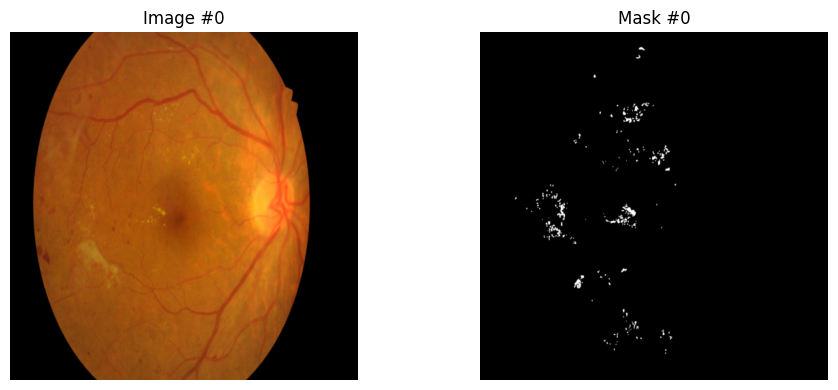

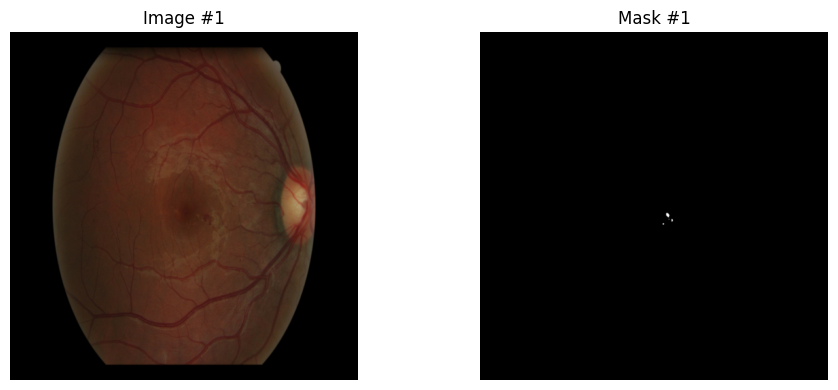

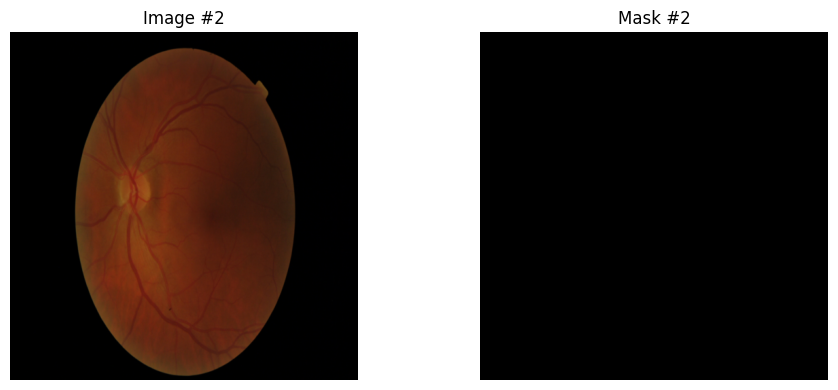

In [54]:
# Show the first 3 test samples
for i in range(3):
    show_dataset_sample(test_dataset, idx=i)

## **Set training parameters**

In [55]:
# model = UNet(num_classes=1).to(device)
# model = load(model_path='/kaggle/input/bce-and-dice/pytorch/default/1/unet_exudates_best.pth').to(device)

class_size = 1
model = smp.Unet(
                    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
                    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                    classes=class_size,                      # model output channels (number of classes in your dataset)
                 ).to(device)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [56]:
# Loss Function (for binary segmentation)
# criterion = nn.BCEWithLogitsLoss()        # first 80 epochs
# criterion = BCEDiceLoss(bce_weight=0.3)

In [57]:
criterion = lambda pred, target: final_loss(pred, target)

In [58]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## **Begin Model training**

In [59]:
epoch_losses, dice_scores, best_dice = train_model(model, 80, train_loader, optimizer, criterion, device)

Epoch [1/80] Started
Epoch [1/80] Finished - Loss: 0.8201 | Dice: 0.0325

Best model updated!
Epoch [2/80] Started
Epoch [2/80] Finished - Loss: 0.7672 | Dice: 0.1413

Best model updated!
Epoch [3/80] Started
Epoch [3/80] Finished - Loss: 0.7456 | Dice: 0.1842

Best model updated!
Epoch [4/80] Started
Epoch [4/80] Finished - Loss: 0.7307 | Dice: 0.2503

Best model updated!
Epoch [5/80] Started
Epoch [5/80] Finished - Loss: 0.7149 | Dice: 0.2377

Epoch [6/80] Started
Epoch [6/80] Finished - Loss: 0.7032 | Dice: 0.2508

Best model updated!
Epoch [7/80] Started
Epoch [7/80] Finished - Loss: 0.6911 | Dice: 0.2592

Best model updated!
Epoch [8/80] Started
Epoch [8/80] Finished - Loss: 0.6713 | Dice: 0.2619

Best model updated!
Epoch [9/80] Started
Epoch [9/80] Finished - Loss: 0.6601 | Dice: 0.2506

Epoch [10/80] Started
Epoch [10/80] Finished - Loss: 0.6417 | Dice: 0.3033

Best model updated!
Epoch [11/80] Started
Epoch [11/80] Finished - Loss: 0.6207 | Dice: 0.2880

Epoch [12/80] Started


## **Model Evaluation**

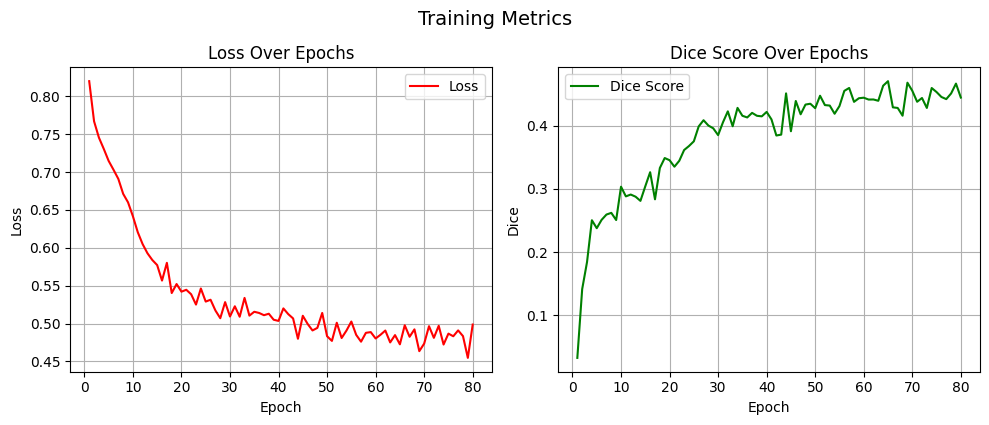

In [60]:
plot_metrics(epoch_losses, dice_scores, title='Training Metrics')

In [61]:
avg_loss, avg_dice, avg_iou, avg_precision, avg_recall = evaluate_model(model, test_loader, criterion, device)

Average Test Loss: 0.6197170138359069
Average Test Dice Scores: 0.43546045571459036
Average Test IoU: 0.3819073909663077
Average Test Precision: 0.3888071268796921
Average Test Recall: 0.17000013841316103


Plotting predictions on 18 test images...


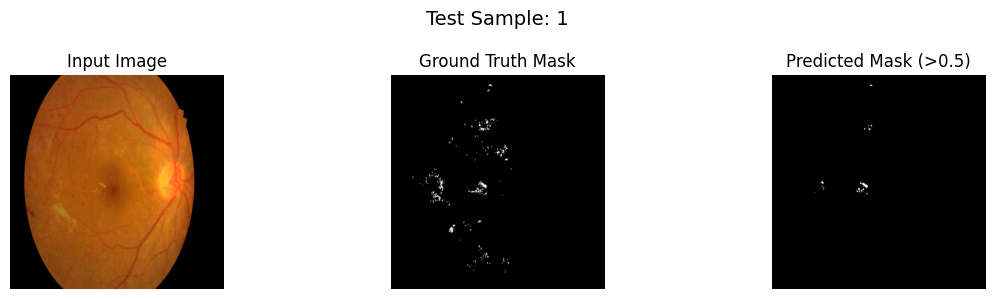

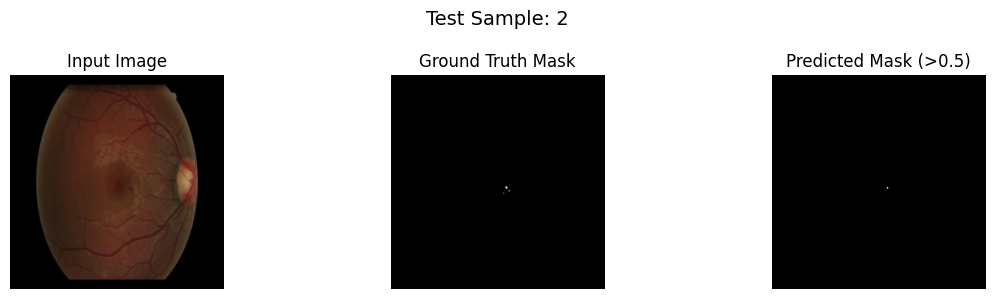

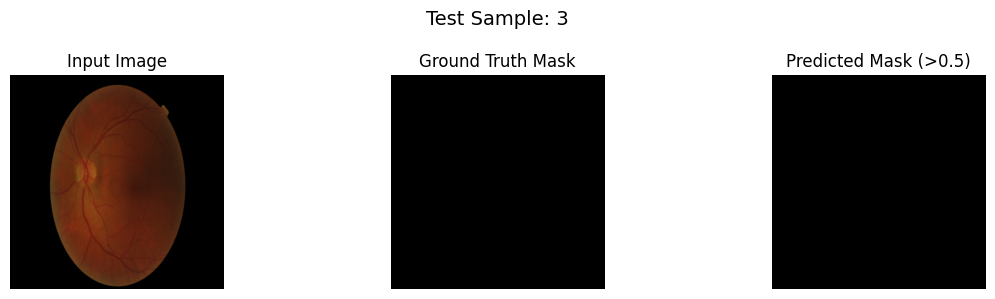

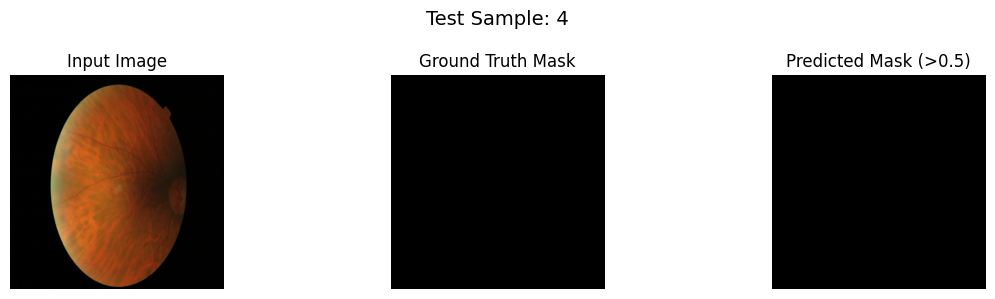

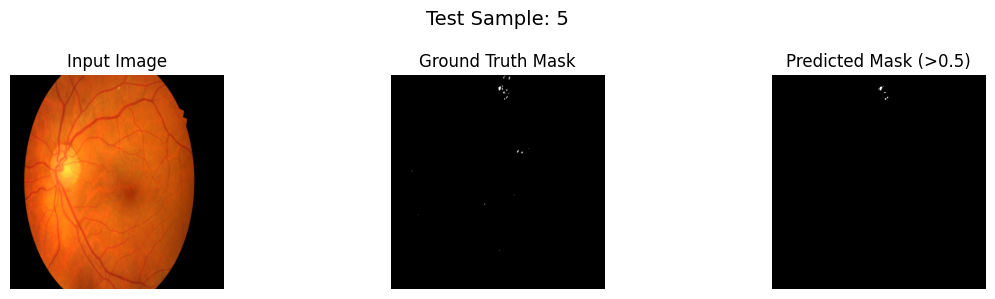

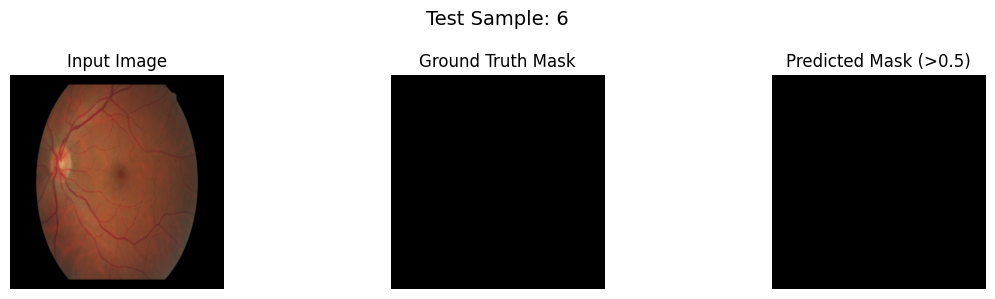

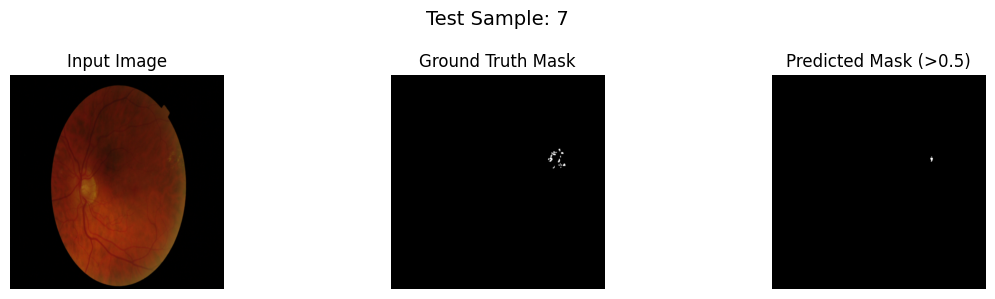

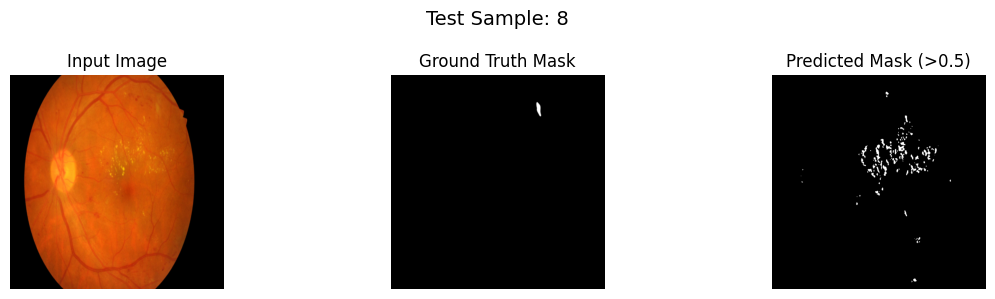

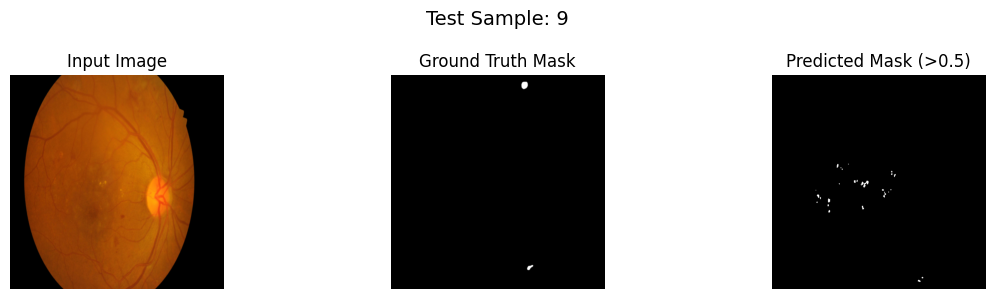

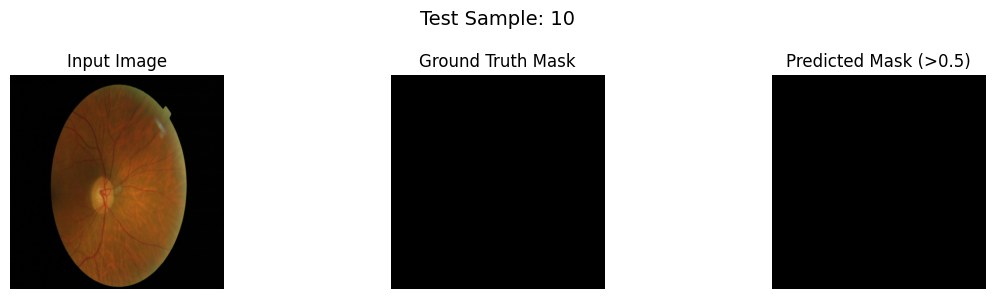

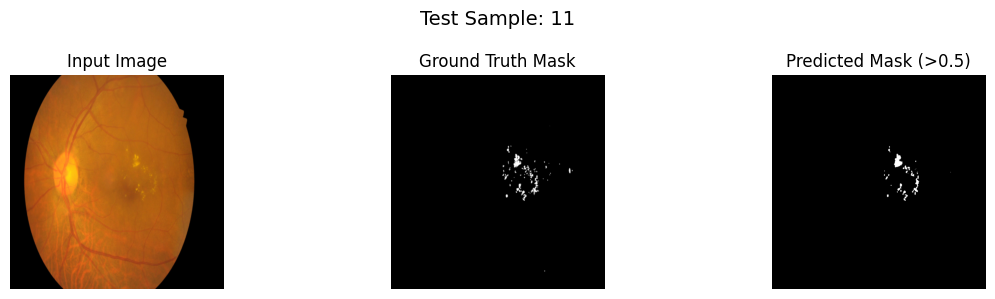

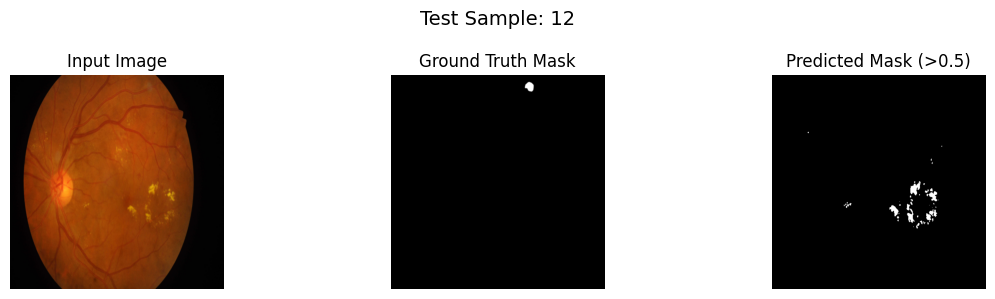

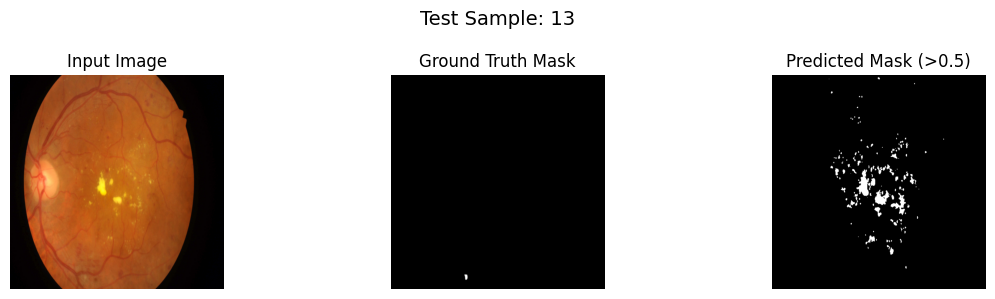

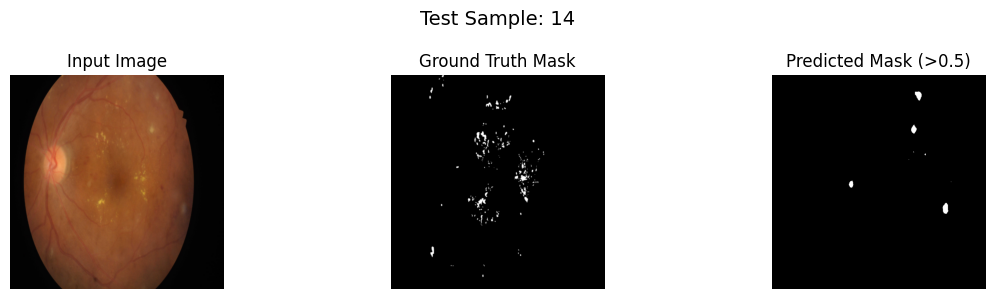

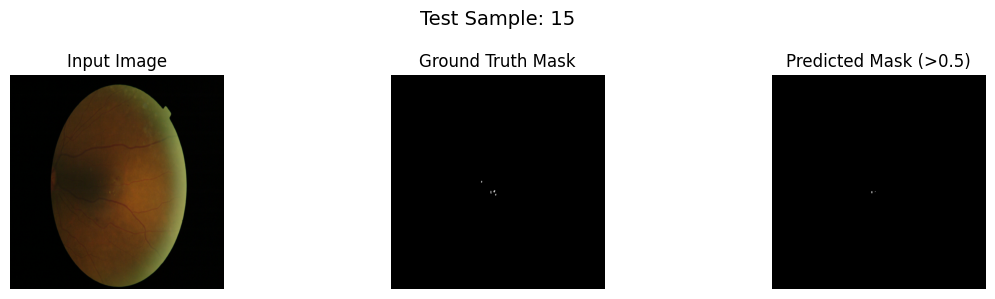

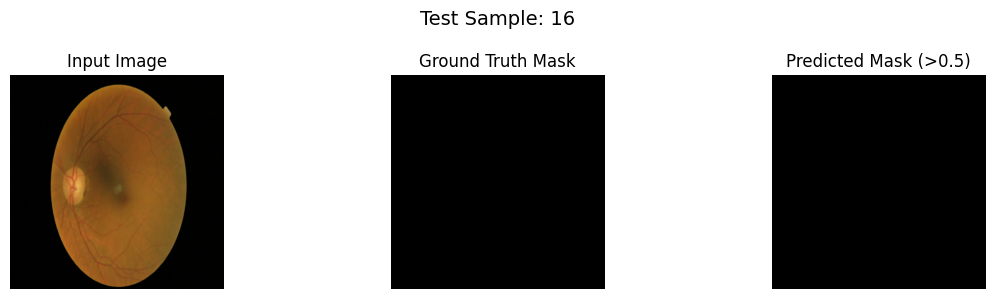

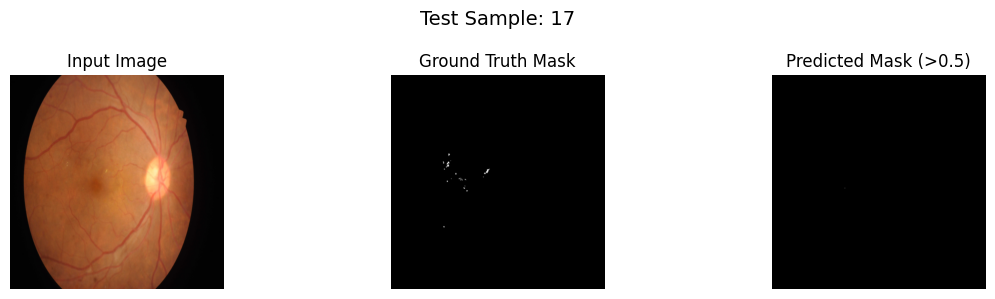

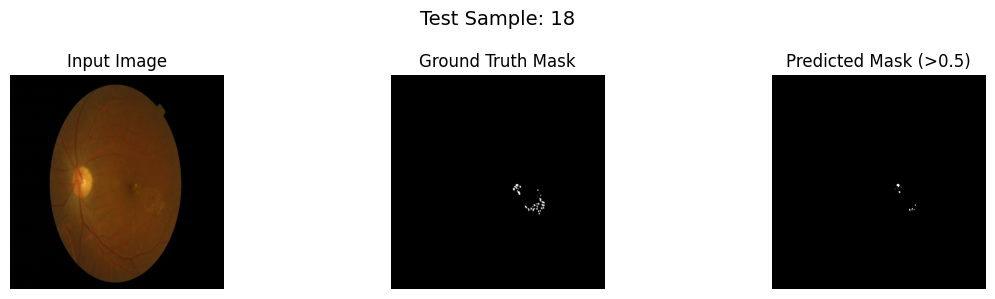

In [62]:
plot_test_predictions(model, test_dataset, device, threshold=0.5, max_images=30)

In [63]:
for sample in test_loader:
    print(sample[0])

('/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/images/IDRiD_27.jpg', '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/EX/E0004082/C0025307.jpg', '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/healthy/E0001626/DS00076K.JPG', '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/healthy/E0000043/DS000DGZ.JPG')
('/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/images/IDRiD_40.jpg', '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/healthy/E0022500/C0001956.jpg', '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/EX/E0017387/DS000U32.JPG', '/kaggle/input/soft-exudates-segmentation/soft exudates segmentation/images/IDRiD_14.jpg')
('/kaggle/input/soft-exudates-segmentation/soft exudates segmentation/images/IDRiD_30.jpg', '/kaggle/input/d/saraelwatany/exudates-segmentation/e_optha_EX/healthy/E0000043/DS000DGV.JPG', '/kaggle/input/hard-exudates-segmentation/hard-exudates-segmentation/imag